In [1]:
# data 폴더에 있는 raw video data를 불러와서 cnn.py의 input으로 가공해줍니다
# data_loader.py - data 폴더에 있는 raw video data를 불러와서 cnn.py의 input으로 가공해주는 function들

# Output Dimensions : 5 (batchsize) x 3 (RGB) x 10 (fps) x 128 (Width) x 128 (Height)
# 하나의 Video 불러와서 window size에 맞게 나누기
## window size = 10 frames (1 second)
## video 하나 당 5개의 windows 생성
## label csv 보고 labelling 까지 attach 해주기

In [2]:
# fname_list = sorted(os.listdir(os.path.join(path_data_prepared,"train")))
# print("original length :", len(fname_list))
# for fname in fname_list:
#     if fname[-3:] != "mp4":
#         fname_list.remove(fname)
#         print(f"* removed '{fname}' from fname_list!")
# print("length after remove :", len(fname_list))

# labels = [fname[-5] for fname in fname_list]
# timestamps = [fname[-10:-6] for fname in fname_list]

# print("-- Length check! -------------------")
# print("| fname_list :", len(fname_list))
# print("| labels :", len(labels))
# print("| timestamps :", len(timestamps))

# print("-- fname_list ----------------------")
# for fname in fname_list:
#     print("|", fname)

# video_path = os.path.join(path_data, "videos_prepared/train/TRAIN_000001_0284_1.mp4")
# video = torchvision.io.read_video(video_path, output_format="TCHW")
# # print(video[2])

# testimg = video[0][0]

# plt.figure()
# plt.imshow(testimg.permute(1,2,0))

# test_transform = transforms.Resize(size=(128,128))
# testimg2 = test_transform(testimg)
# plt.figure()
# plt.imshow(testimg2.permute(1,2,0))
# print(testimg2.shape)

In [3]:
# # 다 완성하면 이거 자체를 함수(또는 클래스)로 만들고, DashcamDataset 부분에도 수정해서 코드 넣기
# # 함수가 input으로 받아야 하는 것 : labels(list), timestamps(list)

# """
#     video별로, {{label_of_window}}를 지정하고 {{label_of_video}}로 변환해주는 함수
#     * {{label}} : 각 window마다 해당하는 label (ex : "0" or "1" or "2")
#     * {{labels_of_video}} : 각 video 별 window들의 label을 연결된 string으로 만든 것 (ex : "0000001110")
#     * {{labels_of_videos}} : {{labels_of_video}}의 리스트 (ex : [ "0000001110", "0000001110", "0000001110" ])
# """

# # (a)직접 입력하는 값
# framenum_per_window = 10
# maxlabelnum_per_window = 3

# # (b)데이터로부터 계산되는 값
# framenum_per_video = 100 # 데이터 받아서 셀 수 있게 변경
# second_per_video = 4 # 데이터 받아서 셀 수 있게 변경

# # (a)&(b)로부터 계산되는 값
# fps = framenum_per_video/second_per_video
# windownum_per_video = int(framenum_per_video/framenum_per_window)

# labels_of_videos = []
# for label, timestamp in zip(labels, timestamps):
#     timestamp = float(timestamp[:2])+(float(timestamp[2:])*1e-2)
#     labels_of_video = list("0"*10)
    
#     # 한 video에서 각 window의 시작 시간
#     starttimes_of_windows = np.zeros((windownum_per_video)) 
#     time_interval = framenum_per_window/fps
#     for windowidx in range(len(starttimes_of_windows)):
#         starttimes_of_windows[windowidx] =  windowidx * time_interval
# #     print(f"\n\n|-> starttimes_of_windows : {starttimes_of_windows}")
    
#     # 사고 시작 시점(timestamp)에 해당되는 window의 index 찾기 : {{timestamp_idx}}
#     timestamp_loc = timestamp < start_time_of_windows
#     if True not in timestamp_loc: # 마지막 window만 해당하는 경우를 위한 예외 처리 (모두 False로 나오기 때문)
#         timestamp_idx = len(timestamp_loc)-1
#         timestamp_loc[timestamp_idx] = True
#     else: # 마지막 window만 해당하는 경우가 아닌 경우
#         timestamp_idx = np.where(timestamp_loc == True)[0][0]-1 
#         timestamp_loc[timestamp_idx] = True
# #     print(f"|-> timestamp_loc : {timestamp_loc}")
# #     print(f"|-> timestamp_idx : {timestamp_idx}")
    
#     # window 당 최대 유효 label 수에 대한 처리 : {{maxlabelnum_per_window}}
#     if collections.Counter(timestamp_loc)[True] > 3:
#         timestamp_loc[timestamp_idx+3:] = False
# #         print(f"|-> timestamp_loc : {timestamp_loc} (after maxlabelnum)")
    
#     # {{labels_of_video}} 변환 
#     idx_valid = np.where(timestamp_loc == True)[0]
#     labels_of_video[idx_valid[0]:idx_valid[-1]+1] = label*len(idx_valid)
# #     print(f"|-> idx_valid : {idx_valid}")
# #     print(f"|-> labels_of_video : {labels_of_video}")
#     labels_of_videos.append("".join(labels_of_video))

# print("\n= labels_of_videos ===========================================================")
# print(labels_of_videos, "\n")
# for result in labels_of_videos:
#     print(result)

In [4]:
import sys, os

import numpy as np
import collections
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

path_pardir = os.pardir # ..
path_data = os.path.join(path_pardir, "data") # ../data
path_data_prepared = os.path.join(path_data, "videos_prepared")
sys.path.append(path_pardir)
sys.path.append(path_data)
sys.path.append(path_data_prepared)

In [5]:
def make_labels_of_videos(
    labels_list, 
    timestamps_list,
    framenum_per_window=10,
    maxlabelnum_per_window=3,
    framenum_per_video=100, # 데이터 받아서 셀 수 있게 변경?
    second_per_video=4 # 데이터 받아서 셀 수 있게 변경?
    ):
    """
        video별로, {{label_of_window}}를 지정하고 {{label_of_video}}로 변환해주는 함수
        * {{label}} : 각 window마다 해당하는 label (ex : "0" or "1" or "2")
        * {{labels_of_video}} : 각 video 별 window들의 label을 연결된 string으로 만든 것 (ex : "0000001110")
        * {{labels_of_videos}} : {{labels_of_video}}의 리스트 (ex : [ "0000001110", "0000001110", "0000001110" ])
    """
    fps = framenum_per_video/second_per_video
    windownum_per_video = int(framenum_per_video/framenum_per_window)

    labels_of_videos = []
    for label, timestamp in zip(labels_list, timestamps_list):
        timestamp = float(timestamp[:2])+(float(timestamp[2:])*1e-2)
        labels_of_video = list("0"*10)

        # 한 video에서 각 window의 시작 시간
        starttimes_of_windows = np.zeros((windownum_per_video)) 
        time_interval = framenum_per_window/fps
        for windowidx in range(len(starttimes_of_windows)):
            starttimes_of_windows[windowidx] =  windowidx * time_interval
    #     print(f"\n\n|-> starttimes_of_windows : {starttimes_of_windows}")

        # 사고 시작 시점(timestamp)에 해당되는 window의 index 찾기 : {{timestamp_idx}}
        timestamp_loc = timestamp < starttimes_of_windows
        if True not in timestamp_loc: # 마지막 window만 해당하는 경우를 위한 예외 처리 (모두 False로 나오기 때문)
            timestamp_idx = len(timestamp_loc)-1
            timestamp_loc[timestamp_idx] = True
        else: # 마지막 window만 해당하는 경우가 아닌 경우
            timestamp_idx = np.where(timestamp_loc == True)[0][0]-1 
            timestamp_loc[timestamp_idx] = True
    #     print(f"|-> timestamp_loc : {timestamp_loc}")
    #     print(f"|-> timestamp_idx : {timestamp_idx}")

        # window 당 최대 유효 label 수에 대한 처리 : {{maxlabelnum_per_window}}
        if collections.Counter(timestamp_loc)[True] > 3:
            timestamp_loc[timestamp_idx+3:] = False
    #         print(f"|-> timestamp_loc : {timestamp_loc} (after maxlabelnum)")

        # {{labels_of_video}} 변환 
        idx_valid = np.where(timestamp_loc == True)[0]
        labels_of_video[idx_valid[0]:idx_valid[-1]+1] = label*len(idx_valid)
    #     print(f"|-> idx_valid : {idx_valid}")
    #     print(f"|-> labels_of_video : {labels_of_video}")
        labels_of_videos.append("".join(labels_of_video))

#     print("\n= labels_of_videos ===========================================================")
#     print(labels_of_videos, "\n")
#     for result in labels_of_videos:
#         print(result)
    
    return labels_of_videos

In [6]:
class DashcamDataset(Dataset):
    def __init__(self, video_dir, video_res=128, transform=None, target_transform=None, train=True):
        if train == True:
            self.video_dir = os.path.join(video_dir, "train") # videos_prepared/train
        else:
            self.video_dir = os.path.join(video_dir, "test") # videos_prepared/test
        self.video_fnames = sorted(os.listdir(self.video_dir))
        for fname in self.video_fnames:
            if fname[-3:]!="mp4": self.video_fnames.remove(fname)
        
        self.video_res = video_res # default 128
        self.video_labels = [fname[-5] for fname in self.video_fnames]
        self.video_tstamps = [fname[-10:-6] for fname in self.video_fnames]
        self.video_tlabels = make_labels_of_videos(self.video_labels, self.video_tstamps)
        
        self.transform = transform # ?
        self.target_transform = target_transform # ?
        
    def __len__(self): # 데이터셋의 샘플 개수 반환
        return len(self.video_labels)
    
    def __getitem__(self, idx):
        video_path = os.path.join(self.video_dir, self.video_fnames[idx])
        video_origin = torchvision.io.read_video(video_path, output_format="TCHW")[0]
        
        # video resolution resizing & permuting       
        video_resized = torch.zeros((video_origin.shape[0],video_origin.shape[1],self.video_res,self.video_res))
#         print("video_resized shape :", video_resized.shape)
        resize_transform = transforms.Resize(size=(self.video_res,self.video_res))
        for iii in range(len(video_origin)):
#             frame_resized = video_origin[iii]
#             frame_resized2 = resize_transform(frame_resized)
#             print(frame_resized2.shape)
#             plt.imshow(frame_resized2.permute(1,2,0))
#             video_resized[iii] = frame_resized2
            video_resized[iii] = resize_transform(video_origin[iii])
        video = video_resized.permute(1,0,2,3) # 차원 순서 변경 : TCHW -> CTHW
        
#         label = self.video_labels # label 오류 : 아래줄로 수정
        label = self.video_tlabels[idx]
        
        if self.transform: video = self.transform(video)
        if self.target_transform: label = self.target_transform(self.video_labels)
            
        return video, label

In [7]:
train_data = DashcamDataset(
    video_dir = path_data_prepared,
)
train_dataloader = DataLoader(train_data, batch_size=5, shuffle=False)

In [8]:
iterator = iter(train_dataloader) # next(iterator)할 때마다 배치 하나씩 받을 수 있음

video_batch1, class_batch1 = next(iterator) # batch 1
video_batch2, class_batch2 = next(iterator) # batch 1
video_batch3, class_batch3 = next(iterator) # batch 1
video_batch4, class_batch4 = next(iterator) # batch 1
video_batch5, class_batch5 = next(iterator) # batch 1
video_batch6, class_batch6 = next(iterator) # batch 1

print(video_batch1.shape)
print(video_batch2.shape)
print(video_batch3.shape)
print(video_batch4.shape)
print(video_batch5.shape)
print(video_batch6.shape)

/Users/kch/opt/anaconda3/envs/DLWithPyTorch/lib/python3.9/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


torch.Size([5, 3, 100, 128, 128])
torch.Size([5, 3, 100, 128, 128])
torch.Size([5, 3, 100, 128, 128])
torch.Size([5, 3, 100, 128, 128])
torch.Size([5, 3, 100, 128, 128])
torch.Size([5, 3, 100, 128, 128])


In [9]:
print(class_batch1)
print(class_batch2)
print(class_batch3)
print(class_batch4)
print(class_batch5)
print(class_batch6)

('0000000111', '0000000111', '0000000111', '0000000111', '0000000111')
('0000000111', '0000000111', '0000000111', '0000000011', '0000000111')
('0000000001', '0000000111', '0000000111', '0000000222', '0000000011')
('0000000111', '0000000111', '0000000111', '0000000222', '0000000022')
('0000001110', '0000000111', '0000001110', '0000000111', '0000002220')
('0000001110', '0000001110', '0000000111', '0000000111', '0001110000')


/var/folders/wz/8cv9d2v5785gtmf1bhybwt040000gp/T/ipykernel_4350/3420446085.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  img1of1 = video_batch1.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
/var/folders/wz/8cv9d2v5785gtmf1bhybwt040000gp/T/ipykernel_4350/3420446085.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify

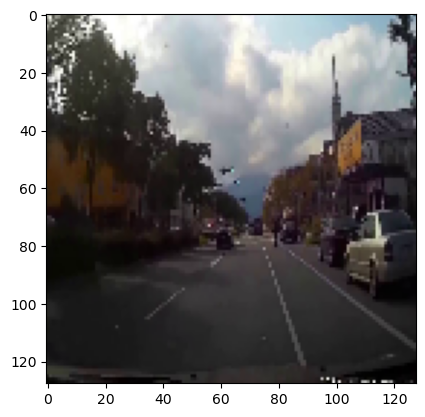

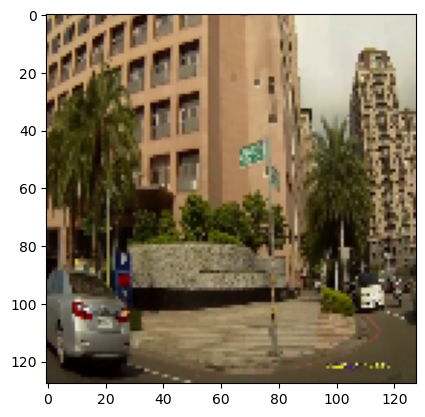

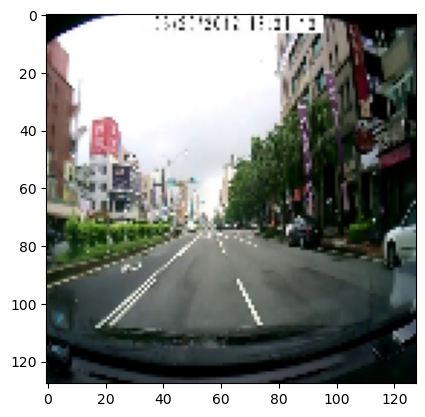

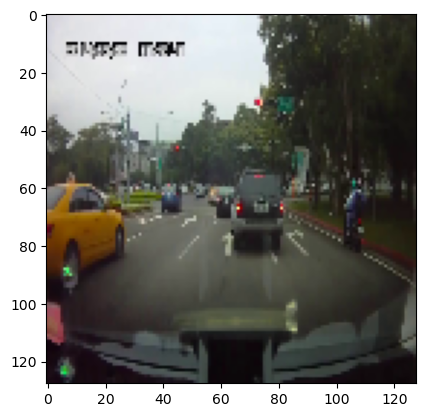

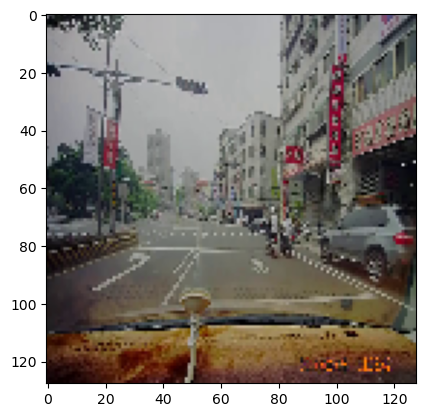

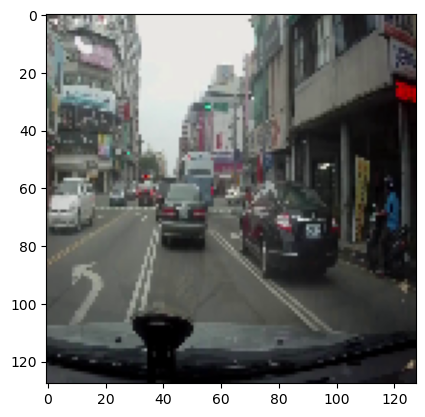

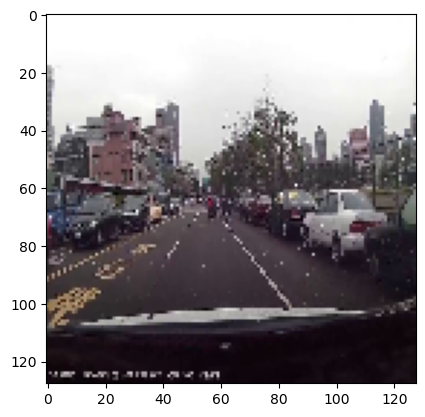

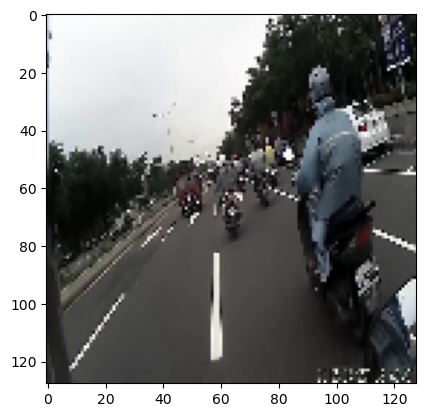

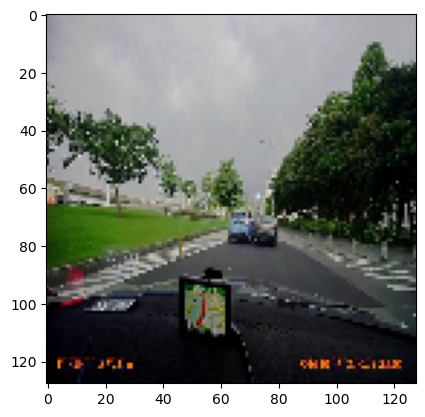

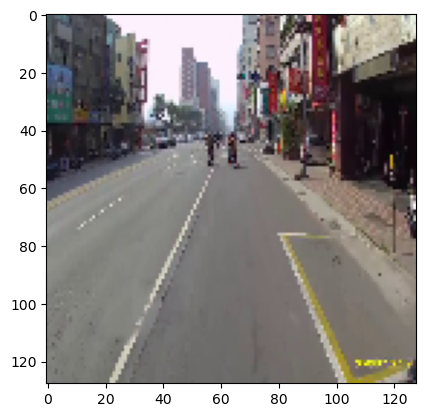

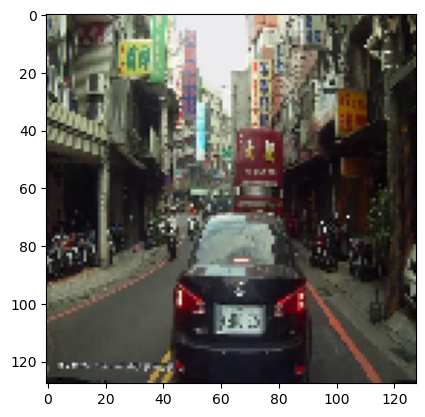

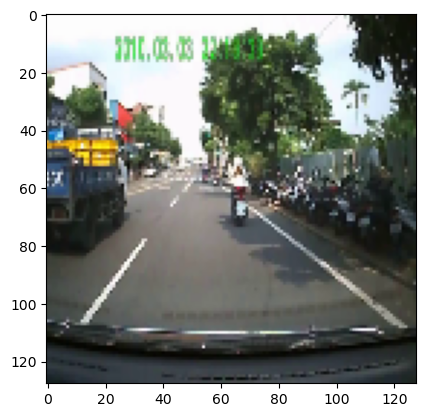

In [10]:
# 배치 별 이미지 2장씩 뽑아보기...

img1of1 = video_batch1.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
img2of1 = video_batch1.permute(0,2,1,3,4)[1][0].permute(1,2,0).numpy().astype(np.int)

img1of2 = video_batch2.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
img2of2 = video_batch2.permute(0,2,1,3,4)[1][0].permute(1,2,0).numpy().astype(np.int)

img1of3 = video_batch3.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
img2of3 = video_batch3.permute(0,2,1,3,4)[1][0].permute(1,2,0).numpy().astype(np.int)

img1of4 = video_batch4.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
img2of4 = video_batch4.permute(0,2,1,3,4)[1][0].permute(1,2,0).numpy().astype(np.int)

img1of5 = video_batch5.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
img2of5 = video_batch5.permute(0,2,1,3,4)[1][0].permute(1,2,0).numpy().astype(np.int)

img1of6 = video_batch6.permute(0,2,1,3,4)[0][0].permute(1,2,0).numpy().astype(np.int)
img2of6 = video_batch6.permute(0,2,1,3,4)[1][0].permute(1,2,0).numpy().astype(np.int)


plt.figure
plt.imshow(img1of1)

plt.figure()
plt.imshow(img2of1)

plt.figure()
plt.imshow(img1of2)

plt.figure()
plt.imshow(img2of2)

plt.figure()
plt.imshow(img1of3)

plt.figure()
plt.imshow(img2of3)

plt.figure()
plt.imshow(img1of4)

plt.figure()
plt.imshow(img2of4)

plt.figure()
plt.imshow(img1of5)

plt.figure()
plt.imshow(img2of5)

plt.figure()
plt.imshow(img1of6)

plt.figure()
plt.imshow(img2of6)

# imgimg = input1.permute(0,2,1,3,4)[0][0]
# plt.figure()
# plt.imshow(imgimg.permute(1,2,0))


# permuted = input1.permute(0,2,1,3,4)
# imgforfor = permuted[0][1].permute(1,2,0).numpy()
# imgforfor = imgforfor.astype(np.int)

# print(imgforfor.shape)
# plt.figure()
# plt.imshow(imgforfor)

# print("classes1 :", classes1)
# # eximg1 = input1.permute(1,0,2,3)[0]
# # plt.imshow(eximg1.permute(1,2,0))

# # plt.figure()
# # input2, classes2 = next(iterator)
# # eximg2 = input2[0][0][0]
# # plt.imshow(eximg2.permute(1,2,0))

# # plt.figure()
# # input3, classes3 = next(iterator)
# # eximg3 = input3[0][0][0]
# # plt.imshow(eximg3.permute(1,2,0))

# # plt.figure()
# # input4, classes4 = next(iterator)
# # eximg4 = input4[0][0][0]
# # plt.imshow(eximg4.permute(1,2,0))

# # plt.figure()
# # input5, classes5 = next(iterator)
# # eximg5 = input5[0][0][0]
# # plt.imshow(eximg5.permute(1,2,0))

# # plt.figure()
# # input6, classes6 = next(iterator)
# # eximg6 = input6[0][0][0]
# # plt.imshow(eximg6.permute(1,2,0))



# #
# #
# #




# # plt.figure()
# # input7, classes7 = next(iterator)
# # eximg7 = input7[0][0][0]
# # plt.imshow(eximg7.permute(1,2,0))

# print(len(input))

# tempimgsample = sample['video'][0][0][0]
# plt.imshow(tempimgsample.permute(1,2,))

# next(train_dataloader)
# tempimgsample = sample['video'][0][0][0]
# plt.imshow(tempimgsample.permute(1,2,))

# next(train_dataloader)
# tempimgsample = sample['video'][0][0][0]
# plt.imshow(tempimgsample.permute(1,2,))

# next(train_dataloader)
# tempimgsample = sample['video'][0][0][0]
# plt.imshow(tempimgsample.permute(1,2,))

# tempimg = train_features[0][0][0]
# plt.imshow(tempimg.permute(1,2,0))


# print(f"Feature batch shape: {len(train_features)}")
# print(f"Labels batch shape: {len(train_labels)}")
# img = train_features[0].squeeze()
# label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
# print(f"Label: {label}")





# a = iter(DataLoader(dataset_iris)) # 이렇게 정의해 두고
# next(a) # 를 계속 실행하면 다음 batch 가 나옴. 출력 잘 나오는지 파악할 때 확인 가능
